In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project.ipynb")

# Final Project <a class='tocSkip'>
    
## PSTAT 134/234 (Fall 2023) <a class='tocSkip'>
    
## Collaboration Policy <a class='tocSkip'>

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *Zexi Ling*

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user. (We won't discuss the role in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha\Gamma_{m-}^T v_m,
\end{aligned}
$$
where $\Gamma_{m-}$ is the $m$-th row of $\Gamma$ (use the notation $\Gamma_{-i}$ for the $i$-th column). When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

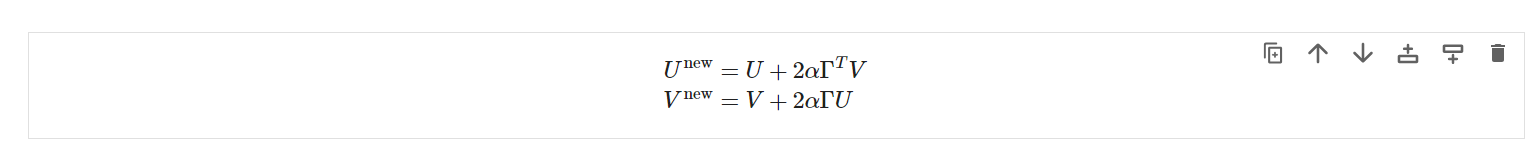

<!-- BEGIN QUESTION --><!-- BEGIN QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [3]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    
    return (R_ - np.matmul(V_, U_.transpose()))

def update_U(G_, U_, V_, alpha=0.01):
    
    return (U_ + 2 * alpha * np.matmul(np.nan_to_num(G_).transpose(), V_))

def update_V(G_, U_, V_, alpha=0.01):
    
    return (V_ + 2 * alpha * np.matmul(np.nan_to_num(G_), U_))

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [4]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [6]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [7]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [8]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [9]:
## TEST ##
output2['U'].shape

(5, 8)

In [10]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [11]:
## TEST ##
output2['V'].shape

(7, 8)

In [12]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [13]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [14]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [15]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [16]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

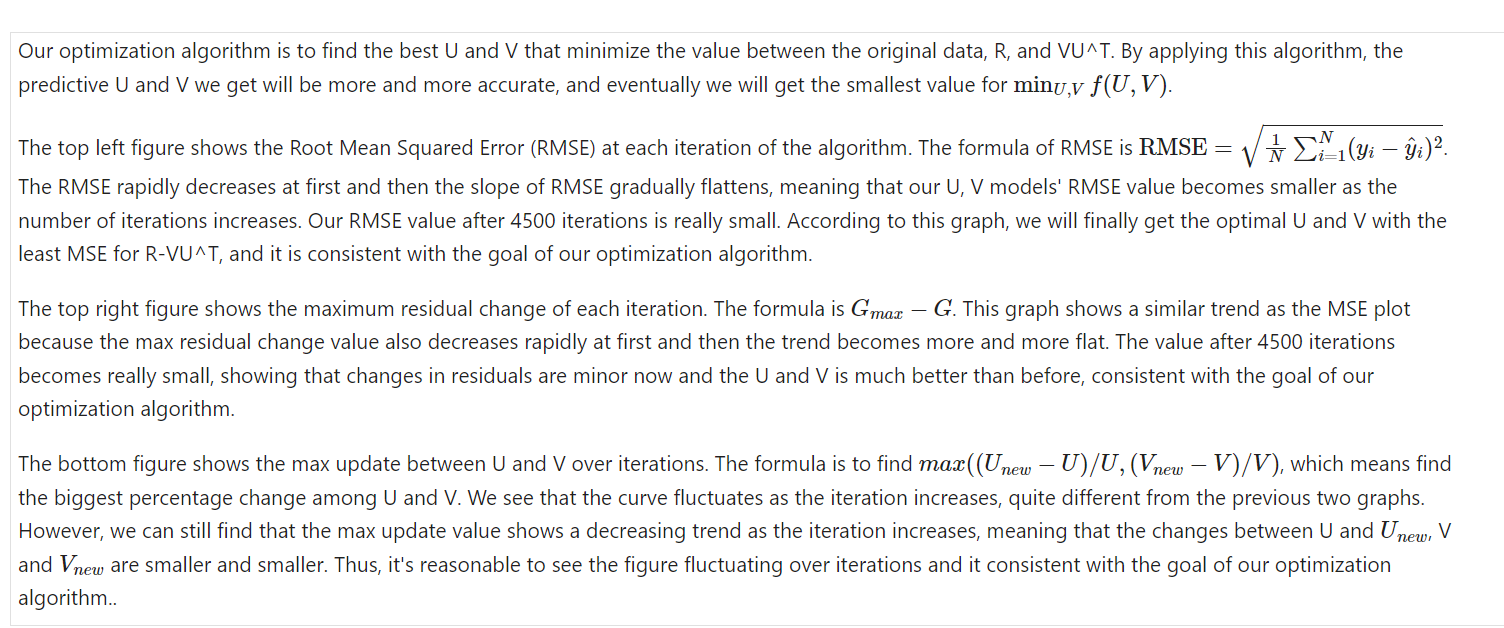

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [17]:
# run on larger dataset: ratings for 100 movies 
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack().iloc[:100]

np.random.seed(14) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [18]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

Consider the above plot. By reading the code, comment on what the plot is illustrating. What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

In [19]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6],
    counts=True
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

This plot visualizes the density of predicted ratings compared to the actual observed ratings, grouped by 5 rating levels. According to this plot, the x-axis represents the fitted ratings estimated by our model, and the y-axis represents the actual ratings made by the users. We use five groups for the whole data set, each representing an actual rating level, so there are five small charts in this plot. 

After adding "counts = True", I found that the shape of the distribution of the five levels changed, and the change was the most obvious for levels 1 and 2. Since the plot with no "counts" has a clearer distribution, it might be better to use that plot to find the relationship between the actual ratings and fitted ratings through the distribution plot. For the plot with "counts = True", since the y-axis represents the number now, it might be better to observe the number of movies in each cluster and also to evaluate how good our model is.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [20]:
rec_movies = Rhatbig.iloc[:,600].sort_values(ascending = False)
rec_movies.head()

movie id  movie title            
13        Mighty Aphrodite (1995)    4.000717
47        Ed Wood (1994)             3.910924
100       Fargo (1996)               3.851010
48        Hoop Dreams (1994)         3.844658
19        Antonia's Line (1995)      3.792223
Name: (rating, 601), dtype: float64

In [21]:
act_movies = Rbig.iloc[:,600].sort_values(ascending = False)
act_movies.head()

movie id  movie title                           
50        Star Wars (1977)                          5.0
91        Nightmare Before Christmas, The (1993)    5.0
64        Shawshank Redemption, The (1994)          4.0
87        Searching for Bobby Fischer (1993)        4.0
65        What's Eating Gilbert Grape (1993)        4.0
Name: (rating, 601), dtype: float64

According to our model, I would recommend Mighty Aphrodite, Ed Wood, Fargo, Hoop Dreams, and Antonia's Dreams to the user 601 since these are the five movies with the top ratings that he would be interested in. According to the movies that the user rated high, I find that he prefers old movies that were made in the 1990s. What's more, both Star Wars and Nightmare Before Christmas are fantasy movies, and he rated the highest (5.0) for these two movies, so maybe he is also interested more in fantasy movies.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|^2 + \sum_{m=1}^{M}\|v_m\|^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

**SOLUTION**

In a vector form, gradients are

$$
\begin{aligned}
\frac{\partial}{\partial u_i} g(u_i, v_m) &= ...\\
\frac{\partial}{\partial v_m} g(u_i, v_m) &= ...
\end{aligned}
$$

By stacking equations, gradients can be expressed in a matrix form as

$$
\begin{aligned}
\frac{\partial}{\partial U} g(U,V) &= ...\\
\frac{\partial}{\partial V} g(U,V) &= ...
\end{aligned}
$$

Finally, the update rules are (in a matrix form)

$$
\begin{aligned}
U^{\text{new}} &= ...\\
V^{\text{new}} &= ...
\end{aligned}
$$

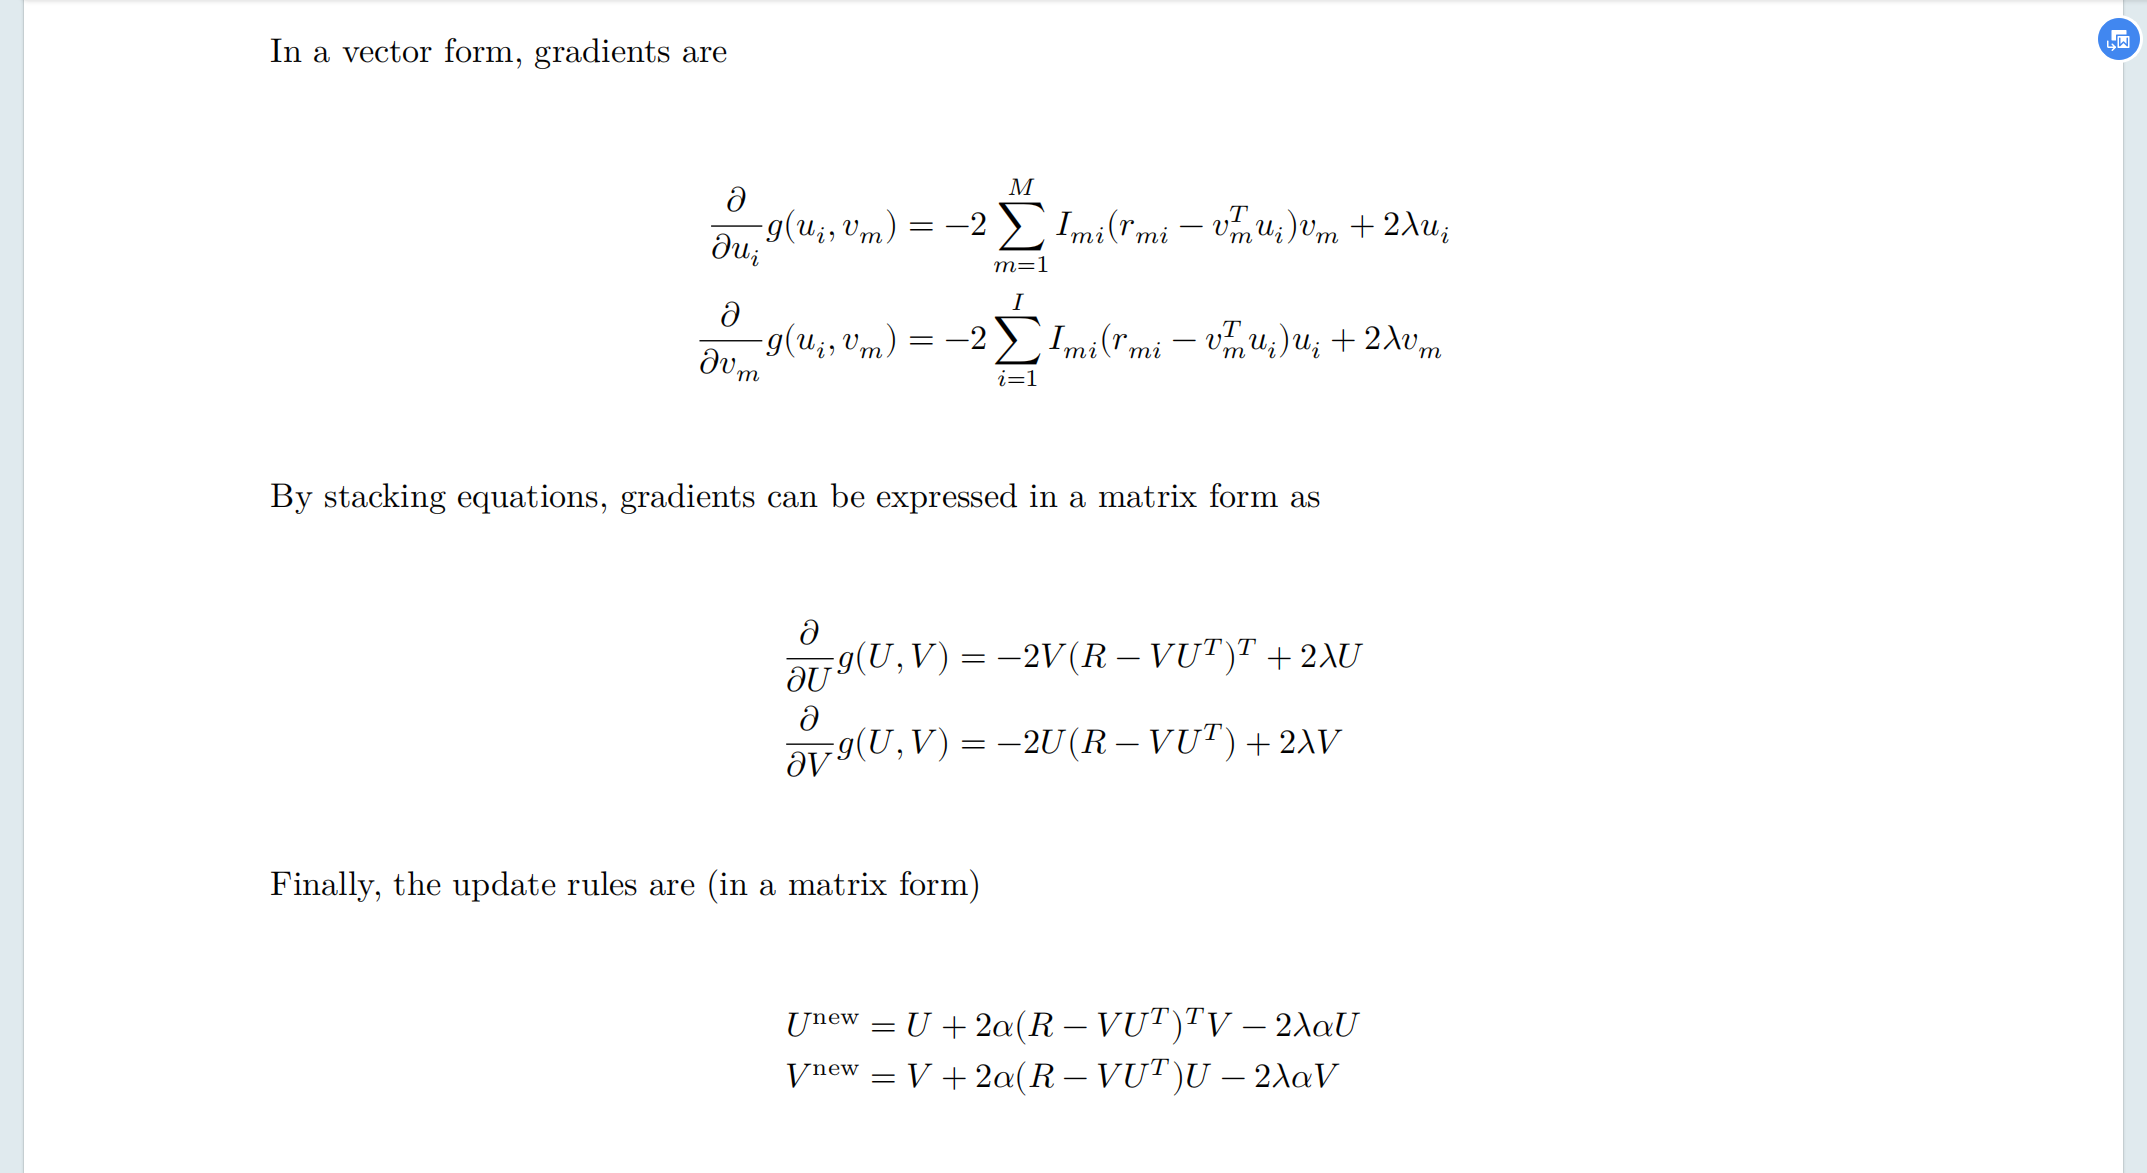

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [22]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - np.matmul(V_, U_.transpose())

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + 2*alpha*(np.matmul(np.nan_to_num(G_).transpose(), V_) - lam*U_)

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + 2*alpha*(np.matmul(np.nan_to_num(G_), U_) - lam*V_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [23]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [24]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [25]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [26]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=10, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=10, lam=1.0, alpha=0.001)

In [27]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [28]:
U_noreg = output_noreg['U']
U_reg = output_reg['U']

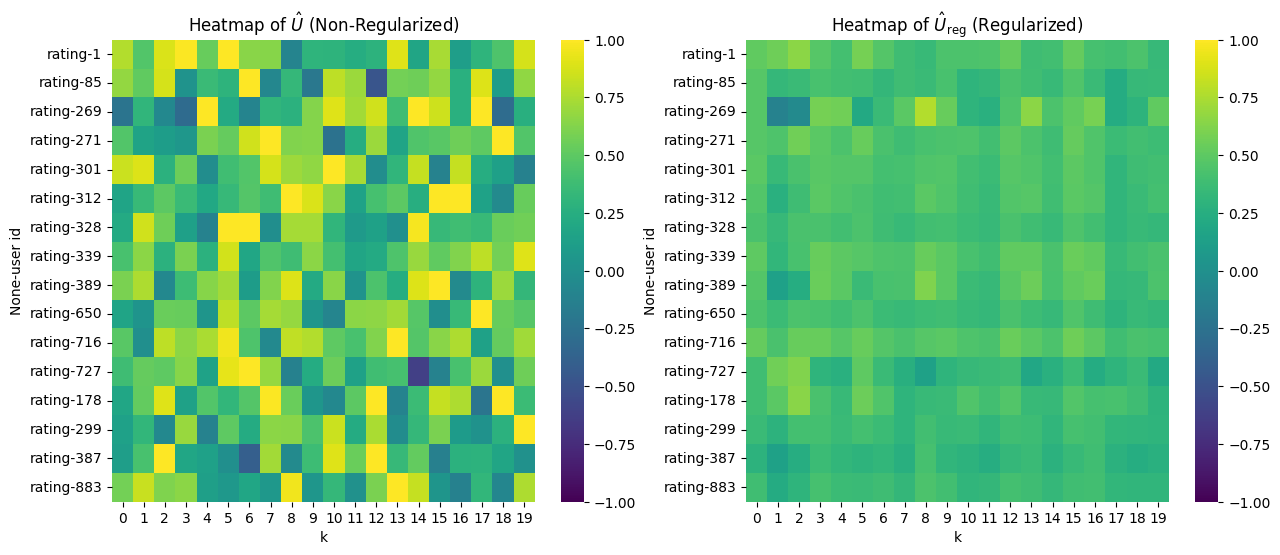

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))

# Non-Regularized U Matrix
plt.subplot(1, 2, 1)
sns.heatmap(U_noreg, cmap="viridis", vmin=-1, vmax=1)
plt.title("Heatmap of $\\hat{U}$ (Non-Regularized)")

# Regularized U Matrix
plt.subplot(1, 2, 2)
sns.heatmap(U_reg, cmap="viridis", vmin=-1, vmax=1)
plt.title("Heatmap of $\\hat{U}_{\\text{reg}}$ (Regularized)")

plt.show()

In [30]:
Rhatreg = output_reg['V']@output_reg['U'].T

fit_vs_obs = pd.concat([
    Rhatreg.rename(columns={'rating':'fit'}),
    Rsmall.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

In [31]:
Rhatnoreg = output_noreg['V']@output_noreg['U'].T

fit_vs_obs = pd.concat([
    Rhatnoreg.rename(columns={'rating':'fit'}),
    Rsmall.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

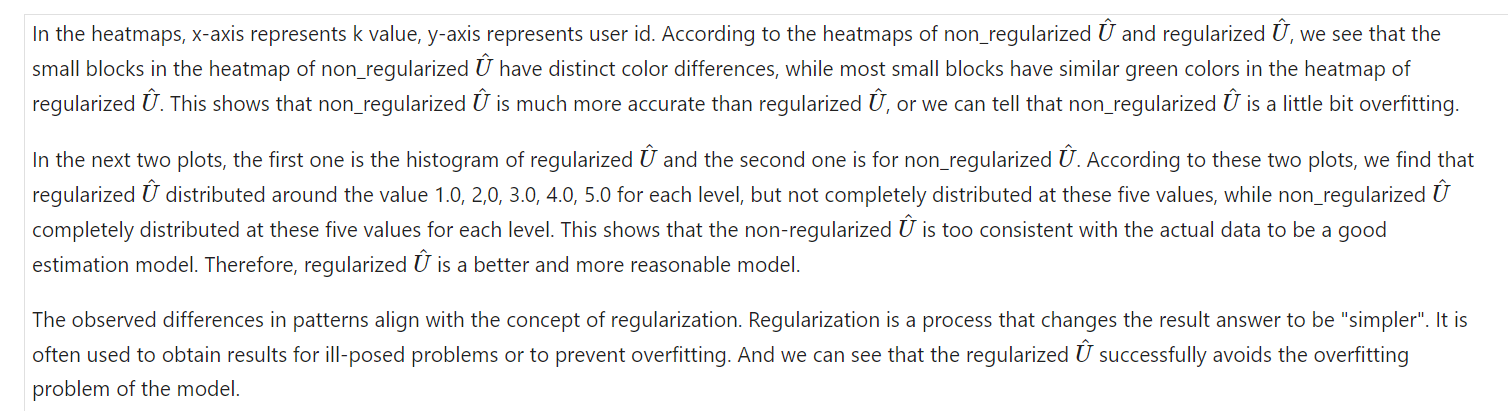

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [32]:
for i in [2,10,20,50]:
    output_reg = compute_UV_reg(Rsmall, K=20, lam=i, alpha=0.001)
    logscale = alt.Scale(type='log', base=10)
    fig_rmse = \
        alt.Chart(output_reg['rmse'])\
        .mark_line()\
        .encode(
            x='iteration:Q', 
            y=alt.Y('rmse:Q', scale=logscale)
        )\
        .properties(title= 'Figure with k = 20')
    display(fig_rmse)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

In [33]:
for j in [2,10,20,50]:
    output_reg = compute_UV_reg(Rsmall, K=j, lam=5.0, alpha=0.001)
    logscale = alt.Scale(type='log', base=10)
    fig_rmse = \
        alt.Chart(output_reg['rmse'])\
        .mark_line()\
        .encode(
            x='iteration:Q', 
            y=alt.Y('rmse:Q', scale=logscale)
        )\
        .properties(title= 'Figure with lambda = 5.0')
    display(fig_rmse)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

While keeping k constant and choosing different lambda (2,10,20,50), we find that the bigger the lambda we choose, the higher the rmse is after a huge number of iterations. Moreover, only the plot with lambda=2 shows a decreasing trend for rmse when iteration increases, other three plots show an increasing trend. This means that a smaller lambda is better for a more accurate model. I think this happens because lambda is a tuning parameter that determines the strength of regularization. If the lambda value is too big, then we will over regularization to make the model too underfit, in this case the rmse will increase.

While keeping lambda constant and choosing different k (2,10,20,50), we find that the bigger the k we choose, the smaller the rmse is after a huge number of iterations. This means that a bigger k is better for a more accurate model. I think this happens because k represents the number of columns for U and V. Thus, the bigger the k value is, the more information we can capture, improving the model accuracy as well as decreasing the rmse. 

Therefore, according to our discoveries, we should choose a small lambda and a big k. Since the rmse values at different k seems to be very similar when the number of iterations is large enough, I think k = 20 is a good value. Moreover, based on the plots, I think lambda = 2 is a good choice since the rmse is the smallest among the 4 candidate values we tried. 

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

**SOLUTION**

In [34]:
# standardize U and V and then concatenate them
from sklearn.preprocessing import StandardScaler
np.random.seed(134)
output_reg = compute_UV_reg(Rbig, K=20, lam = 2, alpha=0.001, max_iteration=600)
U = output_reg['U']
V = output_reg['V']
standardized_U = StandardScaler().fit_transform(U)
standardized_V = StandardScaler().fit_transform(V)
UVstd = np.concatenate((standardized_U, standardized_V), axis = 0)

In [35]:
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Define labels for k-means clustering and hierarchical clustering
hier_cluster = AgglomerativeClustering(n_clusters=5)
hier_labels = hier_cluster.fit_predict(UVstd)
k_cluster = KMeans(n_clusters=5)
k_labels = k_cluster.fit_predict(UVstd)
print('Labels for Hierarchical Clustering',hier_labels)
print('Labels for K-Means Clustering', k_labels)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labels for Hierarchical Clustering [2 0 3 ... 2 2 0]
Labels for K-Means Clustering [4 3 2 ... 4 4 3]


In [36]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score

# Compare three different cluster validation metrics: Silhouette Coefficient, Calinski-Harabasz Index, Davies-Douldin Index
sil_k = metrics.silhouette_score(UVstd, k_labels, metric='euclidean')
sil_hier = metrics.silhouette_score(UVstd, hier_labels, metric='euclidean')

ch_k = metrics.calinski_harabasz_score(UVstd, k_labels)
ch_hier = metrics.calinski_harabasz_score(UVstd, hier_labels)

db_k = davies_bouldin_score(UVstd, k_labels)
db_hier = davies_bouldin_score(UVstd, hier_labels)

Data = {'Silhouette Coefficient':[sil_k,sil_hier], 'Calinski-Harabasz Index':[ch_k,ch_hier],'Davies-Bouldin Index':[db_k,db_hier]}
pd.DataFrame(data = Data, index = ['K-Means Clustering','Hierarchical Clustering'])

,Silhouette Coefficient,Calinski-Harabasz Index,Davies-Bouldin Index
K-Means Clustering,0.092445,66.89036,3.053998
Hierarchical Clustering,0.078218,51.45517,3.421600


Clustering is generally used for unsupervised learning where there is no true label. Since we don't know the ground truth labels, we should use the Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Douldin Index for clustering performance evaluation. Note that for the Silhouette coefficient and Calinski-Harabasz Index, the score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster. For the Davies-Bouldin Index, a lower score relates to a model with better separation between the clusters. Since the K-Means clustering method has a higher Silhouette Score, a higher Calinski-Harabasz Score, and a lower Davies-Douldin Score than the Hierarchical clustering method, we know that the K-Means clustering method performs better on all the 3 validation metrics, so we can expect that the K-Means Clustering method has a better separation between clusters in the plot. Moreover, if I am asked to choose the best cluster validation metrics, it will be hard for me because they have the same drawbacks but have different advantages. I would prefer to choose the Calinski-Harabasz Index since the score is fast to compute through this metric.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [37]:
# install umap
# !pip install umap-learn

In [38]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(UVstd)

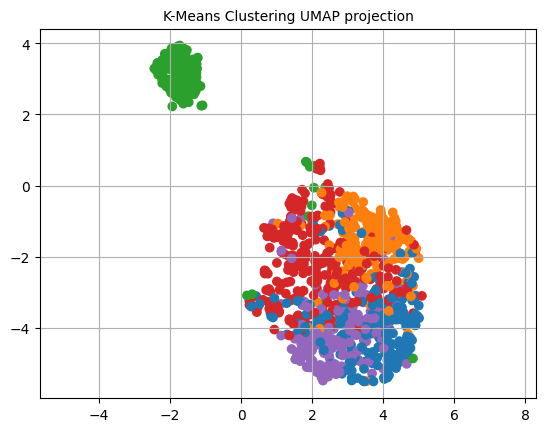

In [39]:
# I choose K-Means Clustering method in 3a, so I will plot K-Means Clustering UMAP
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in k_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.grid(True)
plt.title('K-Means Clustering UMAP projection', fontsize=10);

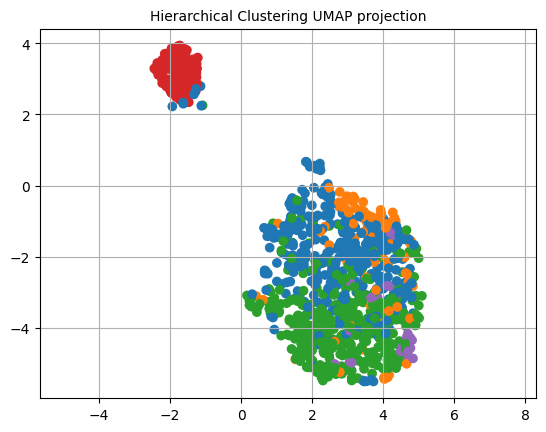

In [40]:
# Though I don't need to plot Hierarchical Clustering UMAP, I still want to see its output so I plot it
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in hier_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.grid(True)
plt.title('Hierarchical Clustering UMAP projection', fontsize=10);

In 3a I concluded that K-Means Clustering would be better so I chose this method to plot, but I also wanted to see the output of the Hierarchical Clustering, so I also plot it. In the K-Means Clustering UMAP projection, we see that each color represents a cluster. I think the clusters and UMAP projection are consistent since we can see that for most of the points with the same color, they are indeed grouped together based on distances, which aligns with the concept of K-Means clustering method.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### (PSTAT 234) Question 3c: Making decisions


To make actionable decisions, there are practical considerations to take into account.

1. How will you choose a "representative" movie from each cluster?
2. How many of each poster do you estimate you will need? Assume the ad campaign will serve 10 million users and 0.01% people will respond. What other assumption do you need to make?
3. Which clustering method will you use as the final method?

**SOLUTION**

1. I will first use the centroids of each cluster to find movies that are the top 5 or top 10 closest to each cluster center. Then, for the selected movies I get from each cluster, I will choose the most popular or highest-rated movie according to the users' ratings to be the "representative". For instance, if the most popular or highest-rated movie among the selected movies in this cluster is a comedy, then we can conclude that users included in this cluster may be interested more in comedy.


2. Since the ad campaign will serve 10 million users and 0.01% people will respond, we can know that only 1000 people will respond. I think we need 200 posters for each "representative" movie since we will select 5 "representative" movies. The other assumptions are: 1. Each user will get only one poster. 2. Posters are distributed randomly 3. The response rate is the same for all clusters.

3. According to 3a, I will use the K-Means Clustering Method since its performance on validation metrics is better than the Hierarchical Clustering Method.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## (PSTAT 234) Question 4: Improving the Model

### Question 4a: Logistic function 

Note the reconstructed ratings can be smaller than 1 and greater than 5. To confine ratings to between the allowed range, we can use the logistic function. Logistic function is defined as 
$$ h(x) = \frac{1}{1+e^{-x}}. $$
It is straightforward to show the derivative is 
$$ h'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = h(x)(1-h(x)). $$
Therefore, we can rescale the ratings from $r_{mi}\in [1, 5]$ to $r_{mi}\in [0, 1]$. Then, we can find the best $U$ and $V$ to optimize the following:
$$ \min_{U,V} \| R - h(VU^T) \|_F^2 = \sum_{m,i} I_{mi}(r_{mi} - h(v_m u_i^T))^2, $$
where function $h$ is applied elementwise and 
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

Derive new update expressions for the new objective function.

**SOLUTION**

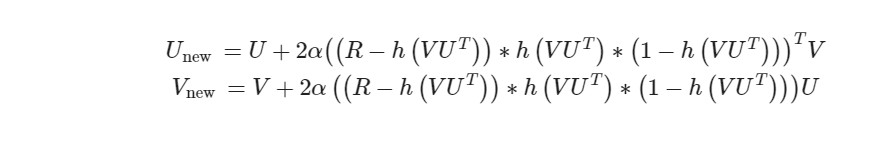

<!-- END QUESTION -->

### Quesiton 4b: Implementation

Implement the update functions in functions below.

In [41]:
def logistic(x):
    """
    Evaluates logistic function
    
    """
    return 1/(1+np.exp(-x))

def update_logistic_G(R_, U_, V_):
    
    return R_ - logistic(np.matmul(V_, U_.transpose()))

def update_logistic_U(G_, U_, V_, alpha=0.01):
    
    logisticVUT = logistic(np.matmul(V_, U_.transpose()))          # estimated ratings
    grad = -2 * np.nan_to_num(G_ * logisticVUT * (1 - logisticVUT)).transpose() @ V_ # gradient direction
    return U_ - alpha * grad                     # gradient descent update from U_

def update_logistic_V(G_, U_, V_, alpha=0.01):
    
    logisticVUT = logistic(np.matmul(V_, U_.transpose()))          # estimated ratings
    grad = -2 * np.nan_to_num(G_ * logisticVUT * (1 - logisticVUT)) @U_ # gradient direction
    return V_ - alpha * grad                     # gradient descent update from V_

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [42]:
grader.check("q4b1")

q4b1 results: All test cases passed!

Now create a function `compute_logistic_UV` below:

In [43]:
def compute_logistic_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    R = (R.copy()-1)/4         # map ratings to between 0 and 1
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape                 # number of movies and users
    U = np.random.rand(I, K)-0.5   # initialize with random numbers
    V = np.random.rand(M, K)-0.5   # initialize with random numbers
    G = update_G(R, U, V)          # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_logistic_U(G, U, V, alpha)
        Gnew = update_logistic_G(R, Unew, V)

        Vnew = update_logistic_V(Gnew, Unew, V, alpha)
        Gnew = update_logistic_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }

def logistic_rating(U_, V_):
    """
    converts the rating back to 1 to 5 rating
    """
    return(4*logistic(V_@U_.T) + 1 )
    
np.random.seed(134) # set seed for tests
output5 = compute_logistic_UV(Rsmall, K=10, alpha=0.05)

In [44]:
grader.check("q4b2")

q4b2 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4c: Analyze a Large Dataset

Following code will analyze a larger dataset:

In [45]:
# run on larger dataset: ratings for 100 movies 
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack().iloc[:100]

np.random.seed(14) # set seed for tests
output6 = compute_logistic_UV(Rbig, K=5, alpha=0.05, max_iteration=500)

Rhatbig = logistic_rating(output6['U'], output6['V'])

In [46]:
fit_vs_obs_2 = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs_2 = fit_vs_obs_2.iloc[np.random.choice(len(fit_vs_obs_2), 5000)]

alt.Chart(fit_vs_obs_2).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

Consider the above plot. By reading the code, comment on what the plot is illustrating. How does this plot look different than part 1.e?

**SOLUTION**

<!-- END QUESTION -->

_Cell Intentionally Blank_

This plot visualizes the density of predicted ratings compared to the actual observed ratings, grouped by 5 rating levels. According to this plot, the x-axis represents the fitted ratings estimated by our model, and the y-axis represents the actual ratings made by the users. We use five clusters for the whole data set, each representing an actual rating level, so there are five small charts in this plot. 

For the graph in 1e, we see that lots of fitted ratings are greater than 5.0 and smaller than 1.0, but the actual ratings should be between 1.0 and 5.0. In this graph, we see that all the ratings are strictly between 1.0 and 5.0, showing that this model is more reliable because there are no outliers.